# Shelf Life Prediction On Fruits and Vegetables

In [1]:
import torch
import os
import glob
import numpy as np
import cv2
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
import torch.nn as nn
from torchvision.models.squeezenet import SqueezeNet
from vit_pytorch import ViT
import torch.optim as optim
from tqdm import tqdm
import pandas as pd
import seaborn as sbn

sbn.set_style('darkgrid')
plt.rcParams['font.family'] = 'IBM Plex Mono'

In [165]:
CLASSES = ["1-5", "5-10", '10-15', 'Expired']

In [176]:
class SLDataset(Dataset):
    def __init__(self):
        self.path = "Data/source"
        self.images = glob.glob(os.path.join(self.path, "*", "*.jpg"))

    def __getitem__(self, index):
        path = self.images[index]
        img = cv2.cvtColor(cv2.imread(path), cv2.COLOR_BGR2RGB)
        img = cv2.resize(img, (224, 224))
        x = torch.from_numpy(np.moveaxis(img, -1, 0)).float()
        y = CLASSES.index(os.path.basename(os.path.dirname(path)))
        y = torch.tensor(y, dtype=torch.long)
        return img, x, y

    def __len__(self):
        return len(self.images)

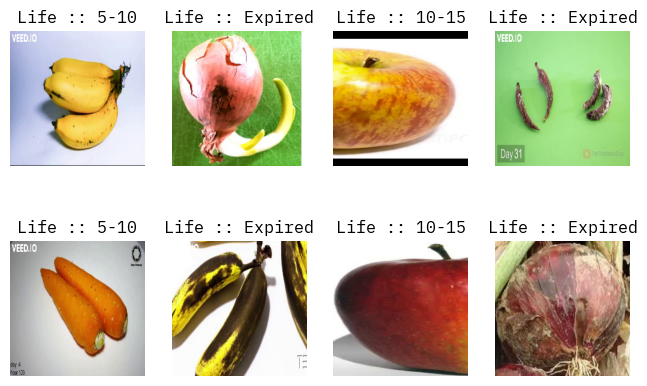

In [177]:
dl = DataLoader(SLDataset(), shuffle=True, batch_size=8)
fig, axes = plt.subplots(2, 4, figsize=(8, 5))
axes = axes.ravel()
for b in iter(dl):
    img, label = b[0], b[2]
    for i, im in enumerate(b[0]):
        axes[i].imshow(im.cpu().numpy())
        axes[i].set_title(f"Life :: {CLASSES[label[i].item()]}")
        axes[i].axis("off")
        if i > 6:
            break
    break

In [182]:
class SqueezeViTClassifier(nn.Module):
    def __init__(self):
        super(SqueezeViTClassifier, self).__init__()
        self.mdl = SqueezeNet()
        self.mdl = nn.Sequential(*list(self.mdl.children())[:-2])
        self.vit = ViT(
            image_size=224,
            patch_size=32,
            num_classes=len(CLASSES),
            dim=512,
            depth=6,
            heads=8,
            mlp_dim=1024,
        )

    def forward(self, x):
        features = self.mdl(x)
        vit_output = self.vit(features)
        y = vit_output.view(vit_output.size(0), -1)
        return y

In [183]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = SqueezeViTClassifier().to(device)
model

SqueezeViTClassifier(
  (mdl): Sequential()
  (vit): ViT(
    (to_patch_embedding): Sequential(
      (0): Rearrange('b c (h p1) (w p2) -> b (h w) (p1 p2 c)', p1=32, p2=32)
      (1): LayerNorm((3072,), eps=1e-05, elementwise_affine=True)
      (2): Linear(in_features=3072, out_features=512, bias=True)
      (3): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
    )
    (dropout): Dropout(p=0.0, inplace=False)
    (transformer): Transformer(
      (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
      (layers): ModuleList(
        (0-5): 6 x ModuleList(
          (0): Attention(
            (norm): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
            (attend): Softmax(dim=-1)
            (dropout): Dropout(p=0.0, inplace=False)
            (to_qkv): Linear(in_features=512, out_features=1536, bias=False)
            (to_out): Sequential(
              (0): Linear(in_features=512, out_features=512, bias=True)
              (1): Dropout(p=0.0, inplace=False

In [184]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
EPOCHS = 100

In [185]:
losses = {"epochs": range(1, EPOCHS + 1), "loss": [], "acc": []}
best_loss = float("inf")
for i in range(EPOCHS):
    model.train()
    with tqdm(total=len(dl)) as pbar:
        running_loss = 0.0
        running_acc = 0.0
        for batch in dl:
            x, y = batch[1].to(device), batch[2].to(device)
            optimizer.zero_grad()
            outputs = model(x)
            loss = criterion(outputs, y)
            _, predicted = torch.max(outputs.data, 1)
            correct = (predicted == y).sum().item()
            acc = correct / dl.batch_size
            running_loss += loss.item()
            running_acc += acc
            loss.backward()
            optimizer.step()
            pbar.set_description(
                "Epoch [{0}/{1}] => Loss :: {2:.4f} | Acc :: {3:.4f} :".format(
                    i + 1, EPOCHS, loss, acc
                )
            )
            pbar.update()
        losses["loss"].append(running_loss / len(dl))
        losses["acc"].append(running_acc / len(dl))
        pbar.set_description(
            "Epoch [{0}/{1}] => Loss :: {2:.4f} | Acc :: {3:.4f} :".format(
                i + 1, EPOCHS, losses['loss'][-1], losses["acc"][-1]
            )
        )
        if losses["loss"][-1] < best_loss:
            best_loss = losses["loss"][-1]
            torch.save(model.state_dict(), "model.pt")

Epoch [1/100] => Loss :: 1.5167 | Acc :: 0.2972 :: 100%|██████████| 225/225 [00:16<00:00, 13.91it/s]
Epoch [2/100] => Loss :: 1.3568 | Acc :: 0.3578 :: 100%|██████████| 225/225 [00:16<00:00, 13.68it/s]
Epoch [3/100] => Loss :: 1.3455 | Acc :: 0.3422 :: 100%|██████████| 225/225 [00:16<00:00, 13.67it/s]
Epoch [4/100] => Loss :: 1.1464 | Acc :: 0.4606 :: 100%|██████████| 225/225 [00:16<00:00, 13.74it/s]
Epoch [5/100] => Loss :: 1.0617 | Acc :: 0.5033 :: 100%|██████████| 225/225 [00:16<00:00, 13.85it/s]
Epoch [6/100] => Loss :: 0.9951 | Acc :: 0.5322 :: 100%|██████████| 225/225 [00:16<00:00, 13.64it/s]
Epoch [7/100] => Loss :: 0.9262 | Acc :: 0.5550 :: 100%|██████████| 225/225 [00:16<00:00, 13.66it/s]
Epoch [8/100] => Loss :: 0.9594 | Acc :: 0.5633 :: 100%|██████████| 225/225 [00:16<00:00, 13.73it/s]
Epoch [9/100] => Loss :: 0.9996 | Acc :: 0.5700 :: 100%|██████████| 225/225 [00:16<00:00, 13.74it/s]
Epoch [10/100] => Loss :: 1.0116 | Acc :: 0.5339 :: 100%|██████████| 225/225 [00:16<00:00, 

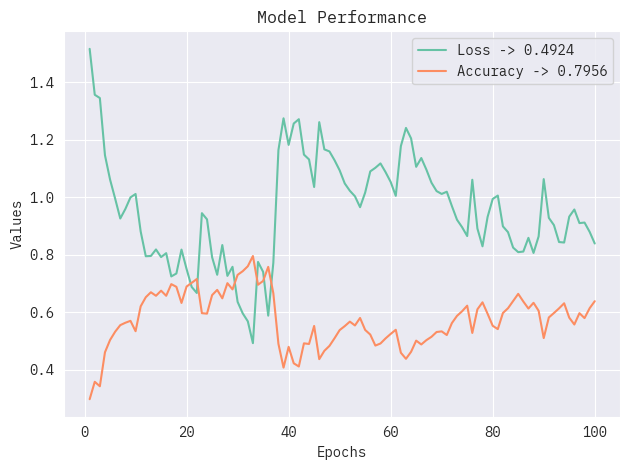

In [188]:
optim_df = pd.DataFrame(losses)
optim_df.columns = ['Epochs', 'Loss', 'Accuracy']
optim_df_melt = pd.melt(optim_df, id_vars=['Epochs'], value_name='Values', value_vars=['Loss', 'Accuracy'])
fig = plt.figure(num=3)
ax = fig.gca()
sbn.lineplot(optim_df_melt, x='Epochs', y='Values', hue='variable', ax=ax, palette='Set2')
ax.set_title('Model Performance')
ax.set_ylabel('Values')
h, _ = ax.get_legend_handles_labels()
ax.get_legend().remove()
ax.legend(h, [
    'Loss -> {0:.4f}'.format(optim_df['Loss'].min()), 
    'Accuracy -> {0:.4f}'.format(optim_df['Accuracy'].max())
])
fig.tight_layout()
fig.savefig('optimization.png')

In [220]:
model = SqueezeViTClassifier().to(device)
model.load_state_dict(torch.load('model.pt'))
y_true = []
prob = []
pred = []
model.eval()
for batch in tqdm(dl, desc='Predicting :'):
    x, y = batch[1].to(device), batch[2].to(device)
    with torch.no_grad():
        y_hat = model(x)
        pred.extend([*y_hat.max(1)[1].cpu().detach().numpy().tolist()])
        prob.extend([*y_hat.cpu().detach().numpy().tolist()])
        y_true.extend([*y.cpu().detach().numpy().tolist()])
y_true = np.array(y_true)
prob = np.array(prob)
pred = np.array(pred)

C:\Users\RaviKumar\AppData\Local\Temp\ipykernel_22592\1095142983.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('model.pt'))
Predicting

In [223]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix

df = pd.DataFrame(zip(['Accuracy', 'Precision', 'Recall', 'F1-Score'], [
    accuracy_score(y_true, pred),
    precision_score(y_true, pred, average='macro'),
    recall_score(y_true, pred, average='macro'),
    f1_score(y_true, pred, average='macro')
]), columns=['Metric', 'Score'])
df.to_csv('metrics.csv', index=False)
df

,Metric,Score
0,Accuracy,0.783333
1,Precision,0.788905
2,Recall,0.773778
3,F1-Score,0.772084


C:\Users\RaviKumar\AppData\Local\Temp\ipykernel_13756\1188994423.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sbn.barplot(df, x='Metric', y='Score', palette='Set2', ax=ax)


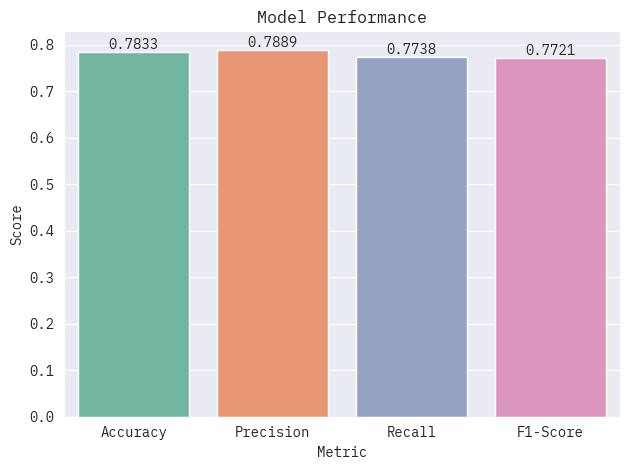

In [7]:
df = pd.read_csv('metrics.csv')
fig = plt.figure()
ax = fig.gca()
sbn.barplot(df, x='Metric', y='Score', palette='Set2', ax=ax)
for c in ax.containers:
    ax.bar_label(c, fmt='%.4f', label_type='edge')
ax.set_title('Model Performance')
fig.tight_layout()
fig.savefig('metrics.png')

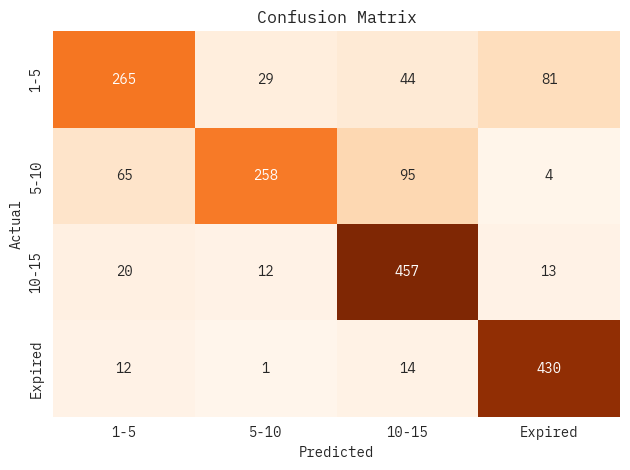

In [227]:
import matplotlib.pyplot as plt
cm = confusion_matrix(y_true, pred)

ax = sbn.heatmap(cm, annot=True, fmt='d', cmap='Oranges', cbar=False)
fig = ax.get_figure()
ax.set_xlabel('Predicted')
ax.set_ylabel('Actual')
ax.set_title('Confusion Matrix')
ax.set_xticklabels(CLASSES)
ax.set_yticklabels(CLASSES)
fig.tight_layout()
fig.savefig('confusion_matrix.png')